In [1]:
import os, sys
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Flatten,Activation
from keras.layers import Conv1D, MaxPooling1D,Dropout,LSTM
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from numpy import zeros
from numpy import asarray
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1445)

Using TensorFlow backend.


### Reading  the Data

In [61]:
Data = pd.read_csv("train-1546603042473.csv")
Data_Test = pd.read_csv("test-1546603743049.csv")

In [62]:
Data.head()

,categories,converse
0,QUERIES FROM PHARMACY,please to verify instructions for drugname pat...
1,NEW APPOINTMENT,lmovm for patients mother to and schd rov trac...
2,OTHERS,labtype and insurance approval other incoming ...
3,OTHERS,clinical list changes medfusion secure electro...
4,MEDICATION RELATED,wants to wean off medication work phone name d...


In [63]:
Data_Test.head()

,id,converse
0,1,request to speak with rn no given patients ref...
1,2,patients husband ret name spouse for other pat...
2,3,fyi in his szs mom other he has an appointment...
3,4,Rx refill drugname from pharmacy name reason f...
4,5,need more time for testing dad is requesting a...


In [64]:
Data.shape

(48699, 2)

### Checking for Na's and Removing Na's

In [68]:
def remove_nas(ds):
    print(ds.shape)
    mis_val = ds.isnull().sum()
    print(mis_val)
    ds.dropna(inplace=True)
    print(ds.shape)
    print(ds.info())

In [69]:
remove_nas(Data)

(48699, 2)
categories     0
converse      32
dtype: int64
(48667, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48667 entries, 0 to 48698
Data columns (total 2 columns):
categories    48667 non-null int32
converse      48667 non-null object
dtypes: int32(1), object(1)
memory usage: 950.5+ KB
None


In [70]:
remove_nas(Data_Test)

(8581, 2)
id          0
converse    4
dtype: int64
(8577, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8577 entries, 0 to 8580
Data columns (total 2 columns):
id          8577 non-null int64
converse    8577 non-null object
dtypes: int64(1), object(1)
memory usage: 201.0+ KB
None


### Checking For Unique Categories

In [71]:
Data['categories'].unique()

array([13,  8,  9,  7, 18, 15, 10, 16, 20,  6,  4, 11,  3, 19, 14, 17,  0,
        2, 12,  5,  1], dtype=int64)

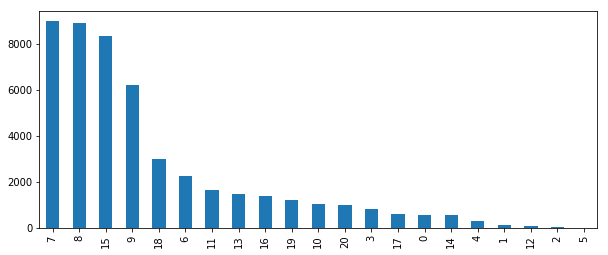

In [72]:
my_tags =['QUERIES FROM PHARMACY', 'NEW APPOINTMENT', 'OTHERS',
       'MEDICATION RELATED',
       'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)', 'REFILL',
       'PRIOR AUTHORIZATION', 'RESCHEDULING', 'SYMPTOMS', 'LAB RESULTS',
       'FOLLOW UP ON PREVIOUS REQUEST', 'PROVIDER', 'CHANGE OF PROVIDER',
       'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)',
       'QUERY ON CURRENT APPOINTMENT', 'RUNNING LATE TO APPOINTMENT',
       'CANCELLATION', 'CHANGE OF PHARMACY',
       'QUERIES FROM INSURANCE FIRM', 'JUNK', 'CHANGE OF HOSPITAL']
plt.figure(figsize=(10,4))
Data.categories.value_counts().plot(kind='bar');

### Label Encoding

In [73]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Data['categories'] = labelencoder.fit_transform(Data['categories'])

### Stop Words Removal

In [74]:
#Remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
Data['converse'] = Data['converse'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
Data['converse'].head()

0    please verify instructions drugname patients w...
1    lmovm patients mother schd rov tracy dominguez...
2    labtype insurance approval incoming name lpn c...
3    clinical list changes medfusion secure electro...
4    wants wean medication work phone name dad pati...
Name: converse, dtype: object

In [76]:
Data['categories'].unique()

array([13,  8,  9,  7, 18, 15, 10, 16, 20,  6,  4, 11,  3, 19, 14, 17,  0,
        2, 12,  5,  1], dtype=int64)

In [14]:
#Total 20 Categories

In [15]:
Data.head()

,categories,converse
0,13,please verify instructions drugname patients w...
1,8,lmovm patients mother schd rov tracy dominguez...
2,9,labtype insurance approval incoming name lpn c...
3,9,clinical list changes medfusion secure electro...
4,7,wants wean medication work phone name dad pati...


In [78]:
Data_Test_converse = Data_Test['converse']
Data_Test_converse.head()

0    request to speak with rn no given patients ref...
1    patients husband ret name spouse for other pat...
2    fyi in his szs mom other he has an appointment...
3    Rx refill drugname from pharmacy name reason f...
4    need more time for testing dad is requesting a...
Name: converse, dtype: object

In [17]:
Data_Test_converse.head()
print(Data_Test_converse.shape)
print(type(Data_Test_converse))

(8577,)
<class 'pandas.core.series.Series'>


### Dividing the Data to docs and Labels

In [18]:
# define documents
docs = []
labels =[]
docs_Test =[]
for row in Data['converse']:
    docs.append(row)
for row_1 in Data['categories']:
    labels.append(row_1)
for row_t in Data_Test_converse:
    docs_Test.append(row)

In [19]:
print(docs[0:5])
print(labels[0:5])
print(Data_Test_converse[0:5])

['please verify instructions drugname patients wi pharmacy target reason call details please verify instructions drugname patients picking Rx timephrase clarified Rx pharmacy lisa gilligan rn', 'lmovm patients mother schd rov tracy dominguez kellee currie pm rhonda fanning', 'labtype insurance approval incoming name lpn clinical review cigna reason call details inform enough information provided patients approved home labtype whitney fax need filled sent questions please whintey rna follow routed wendy upchurch lisa mohamed rn auth obtained routed sleep schedulers tammy byrd fyi wendy upchurch clinical list changes', 'clinical list changes medfusion secure electronic message subject genetic testing hello jennifer wanted update stand far genetic testing concerned working building standard order testing testing administered ground floor building next door seen today contact order sent able obtain cost estimate look forward speaking soon angela cma end message body route responses ansmith

In [20]:
maxlength = len(Data.converse)
maxlength

48667

### Tokeninization

In [21]:
# Prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
#t1.fit_on_texts(docs_Test)
#print (t.word_index)

vocab_size = len(t.word_index) + 1
#vocab_size1 = len(t1.word_index) + 1
print (vocab_size)
#print (vocab_size1)

35607


In [81]:
t.word_index

{'patients': 1,
 'patient': 2,
 'timephrase': 3,
 'mg': 4,
 'rn': 5,
 'drugname': 6,
 'please': 7,
 'rx': 8,
 'rna': 9,
 'labtype': 10,
 'pm': 11,
 'follow': 12,
 'appointment': 13,
 'po': 14,
 'mom': 15,
 'tabs': 16,
 'md': 17,
 'clinical': 18,
 'doctor': 19,
 'list': 20,
 'changes': 21,
 'x': 22,
 'would': 23,
 'name': 24,
 'phone': 25,
 'message': 26,
 'pharmacy': 27,
 'authorized': 28,
 'entered': 29,
 'medication': 30,
 'prescription': 31,
 'states': 32,
 'like': 33,
 'refill': 34,
 'completed': 35,
 'advise': 36,
 'fax': 37,
 'new': 38,
 'back': 39,
 'schedule': 40,
 'request': 41,
 'medications': 42,
 'updated': 43,
 'tab': 44,
 'sent': 45,
 'results': 46,
 'needs': 47,
 'know': 48,
 'spoke': 49,
 'last': 50,
 'pain': 51,
 'order': 52,
 'signed': 53,
 'prior': 54,
 'see': 55,
 'prn': 56,
 'details': 57,
 'need': 58,
 'take': 59,
 'give': 60,
 'rov': 61,
 'scheduled': 62,
 'time': 63,
 'authorization': 64,
 'days': 65,
 'lpn': 66,
 'understanding': 67,
 'medicines': 68,
 'provide

In [22]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
#encoded_docs_Test = t.texts_to_sequences(docs_Test)
encoded_docs_Test = t.texts_to_sequences(Data_Test_converse)
#Data_Test
# print(docs)
# print(encoded_docs)

In [83]:
print(encoded_docs)
print(encoded_docs_Test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [84]:
max_length = 500
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_docs_Test = pad_sequences(encoded_docs_Test, maxlen=max_length, padding='post')
print(padded_docs[0:5])

[[   7  692   80 ...    0    0    0]
 [ 556    1  422 ...    0    0    0]
 [  10  161  468 ...    0    0    0]
 [  18   20   21 ...    0    0    0]
 [  72 1972   30 ...    0    0    0]]


In [85]:
labels = to_categorical(np.asarray(labels))

### Splitting the data 80 20

In [25]:
#Performing train test split on the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2, random_state=14, stratify = labels)
print(type(X_train))
print(type( X_test))
print(type(y_train))
print(type( y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [26]:
#To get the distribution in the target in train and test
print(X_train.shape)
print(X_test.shape)
print(type(X_train))
print(type(y_train))
print(y_train.shape)
print(y_test.shape)

(38933, 500)
(9734, 500)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(38933, 21)
(9734, 21)


# MLP Model

In [27]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
#model.add(Flatten())
model.add(Flatten())
model.add(Dense(21,activation='softmax'))
#model.add(Activation('softmax'))

In [28]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           1780350   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                525021    
Total params: 2,305,371
Trainable params: 2,305,371
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# fit the model
#model.fit(padded_docs, labels, epochs=50, verbose=0)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2,verbose=1)

Train on 38933 samples, validate on 9734 samples
Epoch 1/2
38933/38933 [==============================] - 80s 2ms/step - loss: 1.1465 - acc: 0.6511 - val_loss: 0.8679 - val_acc: 0.7257
Epoch 2/2
38933/38933 [==============================] - 80s 2ms/step - loss: 0.6454 - acc: 0.7923 - val_loss: 0.8491 - val_acc: 0.7288


In [31]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 72.878570


In [32]:
Y_pred_test = model.predict(X_test)
print(Y_pred_test[0:5])

[[3.87952605e-04 3.19981598e-03 2.49547709e-04 4.10718983e-03
  9.67041962e-03 3.76252974e-05 1.86957605e-03 2.50118524e-02
  2.79155723e-03 7.79503956e-02 4.80592344e-03 6.54341141e-03
  7.15535076e-04 1.07757689e-03 3.59886792e-04 6.66558370e-03
  2.81692599e-04 1.24185928e-04 7.91184187e-01 6.25210777e-02
  4.44964040e-04]
 [1.41127128e-03 2.25139735e-03 8.89355579e-05 4.29285737e-03
  1.49699394e-03 8.01630085e-06 2.37766490e-03 5.12825370e-01
  9.08570830e-04 4.26875889e-01 1.89830642e-03 2.90976209e-03
  9.65455023e-04 5.99364867e-05 1.40880086e-02 8.24580714e-03
  5.22280287e-04 1.26885192e-04 1.27912126e-02 8.21351190e-04
  5.03397500e-03]
 [1.18981814e-02 1.56050641e-02 5.20200774e-05 9.27877240e-03
  2.73088692e-03 9.84388134e-06 6.04283111e-03 2.05028191e-01
  1.53604507e-01 8.79466161e-03 5.03632182e-04 4.02233154e-01
  2.69528478e-04 3.08951239e-05 3.95404249e-02 2.08376395e-03
  7.30491616e-03 1.60679265e-04 7.67029542e-03 1.19969428e-01
  7.18825636e-03]
 [1.33302035e-02

In [33]:
y_pred_Test =[]
for i in Y_pred_test:
    y_pred_Test.append(np.argmax(i))

print(y_pred_Test)

[18, 7, 11, 7, 15, 8, 9, 10, 8, 7, 7, 10, 16, 7, 18, 8, 7, 6, 15, 13, 15, 9, 9, 7, 6, 15, 8, 7, 7, 9, 18, 9, 7, 15, 7, 7, 15, 16, 9, 11, 15, 3, 3, 7, 15, 8, 8, 15, 18, 15, 7, 8, 7, 13, 15, 6, 11, 15, 7, 8, 8, 7, 9, 8, 6, 9, 8, 7, 7, 8, 9, 8, 8, 7, 6, 9, 15, 7, 9, 8, 8, 15, 7, 19, 15, 6, 7, 15, 15, 7, 15, 15, 11, 8, 4, 15, 15, 15, 7, 6, 7, 11, 7, 10, 15, 13, 7, 3, 18, 8, 9, 15, 7, 6, 8, 7, 19, 7, 7, 11, 11, 9, 7, 8, 18, 15, 7, 18, 7, 10, 7, 11, 13, 9, 17, 7, 9, 7, 7, 14, 7, 9, 7, 8, 18, 9, 15, 9, 7, 7, 6, 7, 16, 9, 0, 15, 8, 15, 13, 7, 15, 9, 15, 8, 7, 7, 18, 15, 8, 7, 6, 19, 0, 9, 7, 13, 18, 15, 15, 7, 8, 15, 11, 16, 18, 9, 9, 7, 18, 9, 15, 8, 15, 8, 15, 19, 9, 15, 9, 15, 15, 18, 15, 3, 8, 7, 6, 8, 6, 8, 15, 7, 10, 8, 6, 6, 9, 7, 9, 8, 15, 13, 11, 18, 7, 15, 7, 7, 15, 13, 15, 15, 11, 8, 9, 9, 8, 18, 15, 8, 18, 9, 9, 8, 13, 8, 7, 8, 7, 18, 7, 7, 8, 19, 6, 8, 16, 16, 7, 7, 9, 9, 7, 15, 15, 7, 9, 9, 8, 7, 15, 8, 9, 8, 20, 8, 9, 10, 7, 9, 15, 7, 7, 15, 8, 7, 15, 17, 9, 9, 18, 9, 7, 15, 7, 

In [34]:
Y_pred = model.predict(padded_docs_Test)
print(Y_pred[0:5])

[[4.30323358e-04 9.38146608e-04 5.65186419e-05 1.71104865e-03
  6.50398084e-04 2.19328649e-06 4.89805185e-04 9.46420789e-01
  7.71990232e-03 3.52771394e-03 1.15728093e-04 2.00843858e-03
  5.23748386e-05 2.75792081e-05 7.65851839e-03 1.64793134e-02
  8.93036951e-04 1.41648334e-05 2.21885479e-04 4.59417497e-05
  1.05362842e-02]
 [7.28673348e-03 2.21177028e-03 3.46671644e-04 5.28032985e-03
  1.28936814e-03 2.94689293e-04 3.98191530e-03 1.12594031e-01
  2.31752262e-01 5.00374258e-01 4.55054641e-03 8.93552881e-03
  1.11102313e-03 2.75626837e-04 3.13150287e-02 3.49213667e-02
  2.68144943e-02 2.02805176e-03 9.41907428e-03 1.83833181e-03
  1.33788409e-02]
 [9.16828774e-03 3.00551619e-04 1.97770023e-05 7.59764633e-04
  1.78857939e-04 1.31764837e-05 1.61921745e-03 7.32899845e-01
  6.34759665e-02 6.90279976e-02 2.28097269e-04 1.06670614e-03
  7.21649994e-05 2.02557731e-05 3.82791162e-02 1.77775882e-02
  2.65835691e-02 5.38754102e-04 1.08570547e-03 9.23220243e-04
  3.59613672e-02]
 [2.88485880e-09

In [35]:
type(Y_pred)

numpy.ndarray

In [36]:
#print(np.argmax(i))
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

print(y_pred)

[7, 9, 7, 13, 18, 7, 7, 8, 16, 7, 8, 8, 6, 6, 9, 15, 7, 11, 6, 7, 7, 7, 15, 9, 18, 11, 15, 18, 9, 7, 9, 7, 18, 18, 9, 13, 10, 8, 15, 9, 7, 6, 18, 7, 15, 7, 8, 19, 8, 9, 4, 7, 9, 15, 15, 7, 9, 8, 9, 7, 8, 15, 9, 3, 15, 18, 8, 13, 7, 18, 7, 16, 15, 16, 7, 7, 8, 8, 6, 8, 7, 9, 15, 7, 9, 9, 15, 19, 15, 18, 7, 18, 17, 7, 15, 8, 7, 18, 8, 7, 9, 15, 8, 15, 15, 15, 9, 15, 10, 8, 9, 8, 7, 7, 7, 15, 10, 7, 8, 10, 8, 9, 7, 8, 7, 8, 6, 8, 7, 15, 18, 9, 16, 3, 15, 9, 9, 17, 3, 8, 8, 18, 7, 11, 13, 15, 8, 15, 17, 7, 9, 9, 15, 15, 7, 18, 15, 15, 7, 9, 19, 15, 8, 3, 3, 7, 15, 7, 8, 18, 8, 7, 18, 11, 11, 11, 10, 8, 18, 8, 8, 8, 15, 7, 9, 9, 8, 7, 7, 7, 9, 8, 7, 15, 8, 7, 7, 8, 9, 10, 7, 15, 8, 9, 7, 6, 15, 6, 10, 7, 15, 6, 18, 9, 18, 15, 8, 15, 8, 6, 13, 8, 15, 8, 6, 9, 11, 9, 7, 7, 11, 19, 8, 11, 7, 7, 7, 8, 15, 15, 9, 15, 10, 19, 6, 15, 9, 7, 13, 9, 15, 15, 9, 8, 7, 9, 7, 7, 6, 7, 8, 7, 7, 7, 3, 17, 16, 7, 15, 7, 9, 7, 7, 10, 13, 18, 7, 6, 13, 8, 8, 9, 9, 18, 11, 9, 15, 9, 7, 6, 7, 9, 11, 15, 7, 9, 1

In [37]:
op =labelencoder.inverse_transform(y_pred)
d = {'id': Data_Test['id'], 'categories': op}
df = pd.DataFrame(data=d)
df.count()

id            8577
categories    8577
dtype: int64

In [38]:
out_file = 'C:/INSOFE/CuTe_7321_AI/Result.csv'
df.to_csv(out_file, index=False, header=True)
print("Predictions saved: {0}".format(out_file))

Predictions saved: C:/INSOFE/CuTe_7321_AI/Result.csv


In [ ]:
##LSTM

In [86]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_length))
model.add(LSTM(100))
#model.add(Flatten())
model.add(Dense(21,activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           1139424   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 21)                2121      
Total params: 1,194,745
Trainable params: 1,194,745
Non-trainable params: 0
_________________________________________________________________
None


In [87]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3,verbose=1, batch_size=64)

Train on 38933 samples, validate on 9734 samples
Epoch 1/3
38933/38933 [==============================] - 402s 10ms/step - loss: 2.3937 - acc: 0.1792 - val_loss: 2.3776 - val_acc: 0.1851
Epoch 2/3
38933/38933 [==============================] - 399s 10ms/step - loss: 2.3785 - acc: 0.1819 - val_loss: 2.3760 - val_acc: 0.1851
Epoch 3/3
38933/38933 [==============================] - 402s 10ms/step - loss: 2.3776 - acc: 0.1811 - val_loss: 2.3796 - val_acc: 0.1831


In [88]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 18.306965
